In [1]:
from pymongo import MongoClient
from matplotlib import pyplot as plt
import numpy as np
from dcase2020_task2.data_sets.mcm_dataset import INVERSE_CLASS_MAP, TRAINING_ID_MAP, CLASS_MAP
from scipy.stats import rankdata

baseline_auc = {
    'name': 'baseline',
    0: {0: 0.5441, 2: 0.7340, 4: 0.6161, 6: 0.7392},
    1: {0: 0.6715, 2: 0.6153, 4: 0.8833, 6: 0.7455},
    2: {0: 0.9619, 2: 0.7897, 4: 0.9430, 6: 0.6959},
    3: {1: 0.8136, 2: 0.8597, 3: 0.6330, 4: 0.8445},
    4: {1: 0.7807, 2: 0.6416, 3: 0.7535},
    5: {0: 0.6876, 2: 0.6818, 4: 0.7430, 6: 0.5390}
    }
    
baseline_pauc = {
    'name': 'baseline',
    0: {0: 0.4937, 2: 0.5481, 4: 0.5326, 6: 0.5235},
    1: {0: 0.5674, 2: 0.5810, 4: 0.6710, 6: 0.5802},
    2: {0: 0.8144, 2: 0.6368, 4: 0.7198, 6: 0.4902},
    3: {1: 0.6840, 2: 0.7772, 3: 0.5521, 4: 0.6897},
    4: {1: 0.6425, 2: 0.5601, 3: 0.6103},
    5: {0: 0.5170, 2: 0.5183, 4: 0.5197, 6: 0.4843}
}

baseline_both = {}
for t in baseline_auc:
    if t == 'name':
        baseline_both[t] = 'baseline'
        continue
    else:
        baseline_both[t] = {}
    for i in baseline_auc[t]:
        baseline_both[t][i] = np.array([baseline_auc[t][i], baseline_pauc[t][i]])


def get_experiment(runs, name):
    experiment_dict = dict()
    for i in range(6):
        experiment_dict[i] = dict()
    
    experiment_dict['name'] = name
    
    for experiment in runs:
        if experiment['config'].get('id') == name:
            machine_dict = experiment_dict.get(experiment['config']['machine_type'])
            result = experiment.get('result')
            machine_type = INVERSE_CLASS_MAP[experiment['config']['machine_type']]
            machine_id = experiment['config']['machine_id']
            
            if result:
                machine_dict[experiment['config']['machine_id']] = result.get(
                    machine_type, {}
                ).get(
                    f'json://{machine_id}', -1
                ).get('py/tuple', [0, 0])[:2]
            else:
                machine_dict[experiment['config']['machine_id']] = np.array([0, 0])
    return experiment_dict


def get_record(experiment):
    record = []
    for i in range(6):
        for j in TRAINING_ID_MAP[i]:
                v = experiment.get(i)
                if v:
                    v = v.get(j, [0, 0])
                else:
                    v = np.array([0, 0])
                record.append(np.array(v))
    assert len(record) == 23
    return  experiment['name'], record

In [2]:
client = MongoClient('mongodb://student2.cp.jku.at:27017/')
experiments = [r for r in client.resnet_gridsearch.runs.find({"experiment.name": "dcase2020_task2_ClassificationExperiment"})]
print(f'Loaded {len(experiments)} runs.')

Loaded 552 runs.


In [3]:
descriptors = set()
for experiment in experiments:
    descriptors = descriptors.union(set([experiment['config']['id']]))
descriptors = list(descriptors)
print(f'Loaded {len(descriptors)} distinct experiments.')

Loaded 24 distinct experiments.


In [4]:
# Extract Results
# Concatenate Baseline Results
n, m = get_record(baseline_both)
names = [n]
metrics = [np.array(m)]

for descriptor in descriptors:
    n, m = get_record(
            get_experiment(
                experiments, 
                descriptor
            )
        )
    names.append(n)
    metrics.append(np.array(m))

In [5]:
data = np.array(metrics)
auc_ranks = []
pauc_ranks = []
idxes = [0, 4, 8, 12, 16, 19, 23]
for type_, (i, j) in enumerate(zip(idxes[:-1], idxes[1:])):
    average_auc = data[:, i:j, 0].mean(axis=1)
    average_pauc = data[:, i:j, 1].mean(axis=1)
    print(f'Best Model for Machine Type {type_}: {np.argsort(average_auc + average_pauc)[::-1]}')
    auc_ranks.append(rankdata(-average_auc))
    pauc_ranks.append(rankdata(-average_pauc))

Best Model for Machine Type 0: [ 2 11  9 22 20 16  4 18  5 13 24  6 15  0 10 23  8  7 14 17 19  3 21  1
 12]
Best Model for Machine Type 1: [ 2 18 11 16  5  9 24  4 20 22 13 15  6  0 10 23  8  7 14 17 19  3 21  1
 12]
Best Model for Machine Type 2: [18  9 22  2 20  5  4 24 16 11  6 15 13  0 10 23  8  7 14 17 19  3 21  1
 12]
Best Model for Machine Type 3: [ 4 22  6  9 20 11 18  5 24 16 15 13  0 23 10 14  8  7 17 19 21  3  2  1
 12]
Best Model for Machine Type 4: [24  5 22 20 18 16 13 11 15  6  9  4  0 23 10 14  8  7 17 19 21  3  2  1
 12]
Best Model for Machine Type 5: [ 6 15  4 13 18  9 16 11 24 20 22  5  0 23 10 14  8  7 17 19 21  3  2  1
 12]


In [6]:
ranks = np.stack([np.array(list(zip(*auc_ranks))), np.array(list(zip(*pauc_ranks)))], axis=-1).mean(axis=-1).mean(axis=-1)

indices = list(np.argsort(ranks))
names = np.array(names)
for i, (n, r, j) in enumerate(zip(names[indices], ranks[indices], indices)):
    print(f'{i}: ID-{j} {n}')
    

0: ID-18 resnet_gridsearch_a_bit_larger_loose_1e-4_100_BCE
1: ID-9 resnet_gridsearch_a_bit_larger_loose_1e-4_100_AUC
2: ID-22 resnet_gridsearch_a_bit_larger_loose_1e-5_100_BCE
3: ID-4 resnet_gridsearch_a_bit_smaller_loose_1e-4_100_BCE
4: ID-20 resnet_gridsearch_a_bit_larger_loose_1e-5_100_AUC
5: ID-11 resnet_gridsearch_normal_loose_1e-4_100_BCE
6: ID-5 resnet_gridsearch_normal_loose_1e-5_100_BCE
7: ID-16 resnet_gridsearch_normal_loose_1e-4_100_AUC
8: ID-24 resnet_gridsearch_normal_loose_1e-5_100_AUC
9: ID-6 resnet_gridsearch_a_bit_smaller_loose_1e-4_100_AUC
10: ID-13 resnet_gridsearch_a_bit_smaller_loose_1e-5_100_AUC
11: ID-15 resnet_gridsearch_a_bit_smaller_loose_1e-5_100_BCE
12: ID-2 resnet_gridsearch_2_a_bit_larger_loose_1e-4_0.99_100_BCE
13: ID-0 baseline
14: ID-14 resnet_gridsearch_normal_loose_1e-4_100_AUC_rerun
15: ID-10 resnet_gridsearch_a_bit_larger_loose_1e-5_100_AUC_rerun
16: ID-8 resnet_gridsearch_a_bit_smaller_loose_1e-4_100_BCE_rerun
17: ID-17 resnet_gridsearch_a_bit_larg

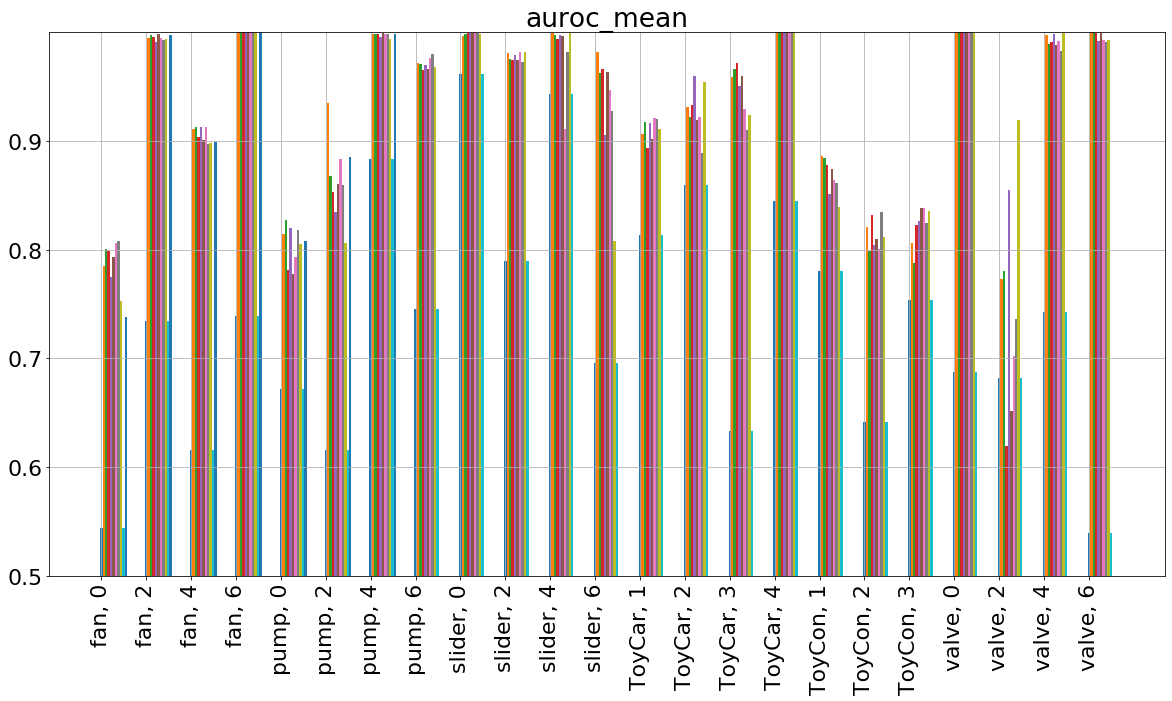

(11, 23, 2)

In [79]:
metric = 'auroc_mean'
bar_width = 0.6
bar_spacing=0.00
top = 10

top_k_data = data[indices, :, 0 if metric == 'auroc_mean' else 1][:top]
baseline_data = data[0:1, :, 0 if metric == 'auroc_mean' else 1]
to_visualize = np.concatenate([baseline_data, top_k_data])

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title(f'{metric}')
labels = []

for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))

for i, d in enumerate(to_visualize):
    plt.bar(
        np.arange(len(labels)) + i * (bar_width / len(to_visualize) + bar_spacing), 
        d,
        bar_width/ len(to_visualize),
    )

plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.ylim(0.5, 1.)
plt.yticks(np.arange(0.5, 1., 0.1))
plt.grid()
plt.savefig(f'top_{top}_auc.png')
plt.show()

data.shape

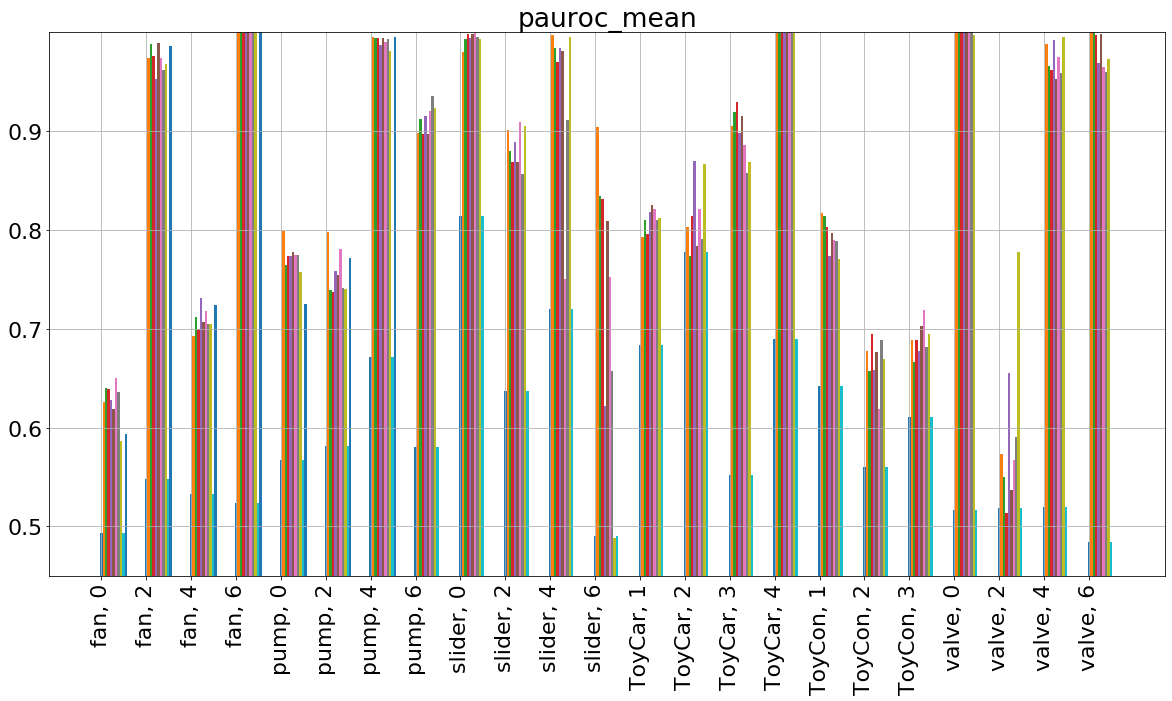

(11, 23, 2)

In [77]:



metric = 'pauroc_mean'
bar_width = 0.6
bar_spacing=0.00
top = 10

top_k_data = data[indices, :, 0 if metric == 'auroc_mean' else 1][:top]
baseline_data = data[0:1, :, 0 if metric == 'auroc_mean' else 1]
to_visualize = np.concatenate([baseline_data, top_k_data])

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title(f'{metric}')
labels = []

for i in range(6):
    for j in TRAINING_ID_MAP[i]:
        labels.append("{}, {}".format(INVERSE_CLASS_MAP[i][:6], j))

for i, d in enumerate(to_visualize):
    plt.bar(
        np.arange(len(labels)) + i * (bar_width / len(to_visualize) + bar_spacing), 
        d,
        bar_width/ len(to_visualize),
    )

plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.ylim(0.45, 1.)
plt.yticks(np.arange(0.5, 1., 0.1))
plt.grid()
plt.savefig(f'top_{top}_auc.png')
plt.show()

data.shape